In [71]:
import os
import re

import numpy as np
import mlflow

print(os.getcwd())
if os.getcwd().endswith("/multiobjective_opt/notebooks"):
    os.chdir("..")

/home/xxam_xam/my_files/multiobjective_opt


In [59]:
EXP_NAME = "new_experiments"

experiment = mlflow.get_experiment_by_name(EXP_NAME)
runs = mlflow.search_runs(experiment.experiment_id)

In [89]:
def exp_selector(name):
    # return re.match(pattern, name)
    return name == "mab_train;range(0,20);10:18"

selected_experiments_pos = runs["tags.mlflow.runName"].apply(exp_selector)

exp_ids = runs[selected_experiments_pos]["run_id"].values
exp_ids
# artifact_path = mlflow.artifacts.download_artifacts(run_id=run_id, artifact_path="run_results_table.json")

array(['6b8ead101e50456e90be98a8b5f3012b'], dtype=object)

In [62]:
client = mlflow.MlflowClient()

run_id = exp_ids[0]
run = client.get_run(run_id)

In [65]:
metric_names = list(run.data.metrics.keys())
metric_names

['pull_rew.confidence_bound',
 'pull_rew.value',
 'pull_rew.eval_rez.duration',
 'pulled_arm',
 'test_rew.loss',
 'pull_rew.eval_rez.loss',
 'test_rew.duration',
 'pull_rew.eval_rez.accuracy',
 'test_rew.accuracy']

In [102]:
alg_names = run.data.params["alg_names"]
alg_names

"['ShallowMLP', 'ResNet18', 'DeepMLPNorm', 'VGGLike', 'DeepMLP']"

In [87]:
def parse_values(f, n_arms, arm_key, duration_key):
    def get_placeholder_for_val():
        return np.zeros((len(f) - n_arms,n_arms))
    
    duration = np.zeros(n_arms, float)
    key_res = {key: get_placeholder_for_val() for key in f[0].keys()}
    
    for i, elem in enumerate(f[:n_arms]):
        # инициализируем значения
        arm = elem[arm_key]
        duration[arm] = elem[duration_key] - (f[i-1][duration_key] if i > 0 else 0)
        for k, v in elem.items():
            key_res[k][0][arm] = v
    
    # заполнение
    for i, elem in enumerate(f[n_arms:-1], 1):
        if len(elem) == 0:
            continue
        arm = elem[arm_key]
        duration[arm] += elem[duration_key] - f[ i + n_arms - 2][duration_key]

        for k, v in elem.items():
            key_res[k][i] = key_res[k][i - 1]
            key_res[k][i][arm] = v

    return duration, key_res

In [88]:
T = 355
N_ARMS = 5
arm_key = "pulled_arm"
duration_key = 'pull_rew.eval_rez.duration'


client = mlflow.MlflowClient()
keys = [
        'pulled_arm',

        'pull_rew.confidence_bound',
        'pull_rew.value',

        'pull_rew.eval_rez.loss',
        'pull_rew.eval_rez.duration',
        'pull_rew.eval_rez.accuracy',

        'test_rew.loss',
        'test_rew.duration',
        'test_rew.accuracy'
    ]

results = []
for run_id in exp_ids:
    # process for one run
    # try:
        run_res = [dict() for _ in range(T)]
        for key in keys:
                metric_h = client.get_metric_history(run_id, key=key)
                
                for i, elem in enumerate(metric_h):
                    run_res[i][key] = int(elem.value) if key == "pulled_arm" else elem.value
            
        print(run_res[2]["pulled_arm"])
        if len(run_res[0]) < 1:
               continue
               
        parsed_run = parse_values(run_res, N_ARMS, arm_key, duration_key)
        results.append(parsed_run)
    # except IndexError as e:


0


In [94]:
def get_loss_hist(key = "loss"):
    run_loss_hist = [r[1][key].T for r in results]
    return run_loss_hist


In [103]:
from multiobjective_opt.utils.utils import LINESTYLES
from multiobjective_opt.utils.utils import get_fig_set_style
LINESTYLES = [
    ("densely dashed", (0, (3, 1))),
    ("d", "solid"),
    ("d", "dotted"),
    ("d", "dashdot"),
    ("dashdotted", (0, (3, 1, 3, ))),
    ("densely dashed", (0, (5, 1))),
    ("densely dashdotdotted", (0, (3, 1, 1, 1, 1, 1))),
    ("long dash with offset", (1, (1, 0))),
    ("dashed", (0, (5, 5))),
    ("d", "dashed"),
    ("loosely dashdotdotted", (0, (3, 10, 1, 10, 1, 10))),
    ("densely dashdotted", (0, (3, 1, 1, 1))),
    ("dashdotdotted", (0, (3, 5, 1, 5, 1, 5))),
    ("densely dotted", (0, (1, 1))),
    ("long dash with offset", (5, (10, 3))),
    ("loosely dashdotted", (0, (3, 10, 1, 10))),
    ("densely dashdotdotted", (0, (3, 1, 1, 1, 1, 1))),
    ("loosely dashed", (0, (5, 10))),
    ("dashdotdotted", (0, (3, 5, 1, 5, 1, 5))),
    ("loosely dashdotdotted", (0, (3, 10, 1, 10, 1, 10))),
]

import matplotlib.pyplot as plt

import numpy as np

# from multiobjective_opt.utils import LINESTYLES, get_fig_set_style
def plot_vals(ax, run_hist, ylabel, ylim):
    losses = np.stack(run_hist)
    mean_loss = losses.mean(0)
    low_loss = np.quantile(losses, 0.1, 0)
    high_loss = np.quantile(losses, 0.9, 0)


    colors = ["r", "g", "black", "navy", "brown", "blue", "purple", 'darkgreen',]
    markers = ["<", "o", "D", ">", 's']
    nums = [19, 18, 25, 20, 22]
    # model_names = [elem[0] for elem in list(tab.values())[1]]
    print("HARDCODED model names order")
    model_names = ['ShallowMLP', 'ResNet18', 'DeepMLPNorm', 'VGGLike', 'DeepMLP']
    # model_names = ["Linear", "MLP", "Conv2Layer", "Conv3Layer", "ConvDropout", "ConvBatchNorm", "ResNet18"]
    for i, (loss, low, high, color, m_name, ls, m, n) in enumerate(zip(mean_loss, low_loss, high_loss, colors, model_names, LINESTYLES, markers, nums)):
        # plt.fill_between(x, loss - std,loss + std , color=color, alpha=0.1,)
        if m_name == "VGGLike":
             m_name = "VGG"
        if "Conv" in m_name:
             continue
        ax.plot(loss, label = m_name, color = color, linestyle=ls[1], marker = m, 
                            markersize = 10, 
                            markeredgewidth=2, 
                            markerfacecolor='white',
                            markeredgecolor='black',
                            markevery = n)
        print(m_name, ls[0])
        x = np.arange(len(loss))
        # if m_name in ["ResNet18", "ConvBatchNorm"]:
        ax.fill_between(x, low, high, color=color, alpha=0.1,)

    ax.set_ylim(ylim)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(r"$\#$ iterations")
    ax.grid()
    # ax.legend()


HARDCODED model names order
ShallowMLP densely dashed
ResNet18 d
DeepMLPNorm d
VGG d
DeepMLP dashdotted
HARDCODED model names order
ShallowMLP densely dashed
ResNet18 d
DeepMLPNorm d
VGG d
DeepMLP dashdotted
['ShallowMLP', 'ResNet18', 'DeepMLPNorm', 'VGG', 'DeepMLP']
HARDCODED model names order
ShallowMLP densely dashed
ResNet18 d
DeepMLPNorm d
VGG d
DeepMLP dashdotted
HARDCODED model names order
ShallowMLP densely dashed
ResNet18 d
DeepMLPNorm d
VGG d
DeepMLP dashdotted
['ShallowMLP', 'ResNet18', 'DeepMLPNorm', 'VGG', 'DeepMLP']


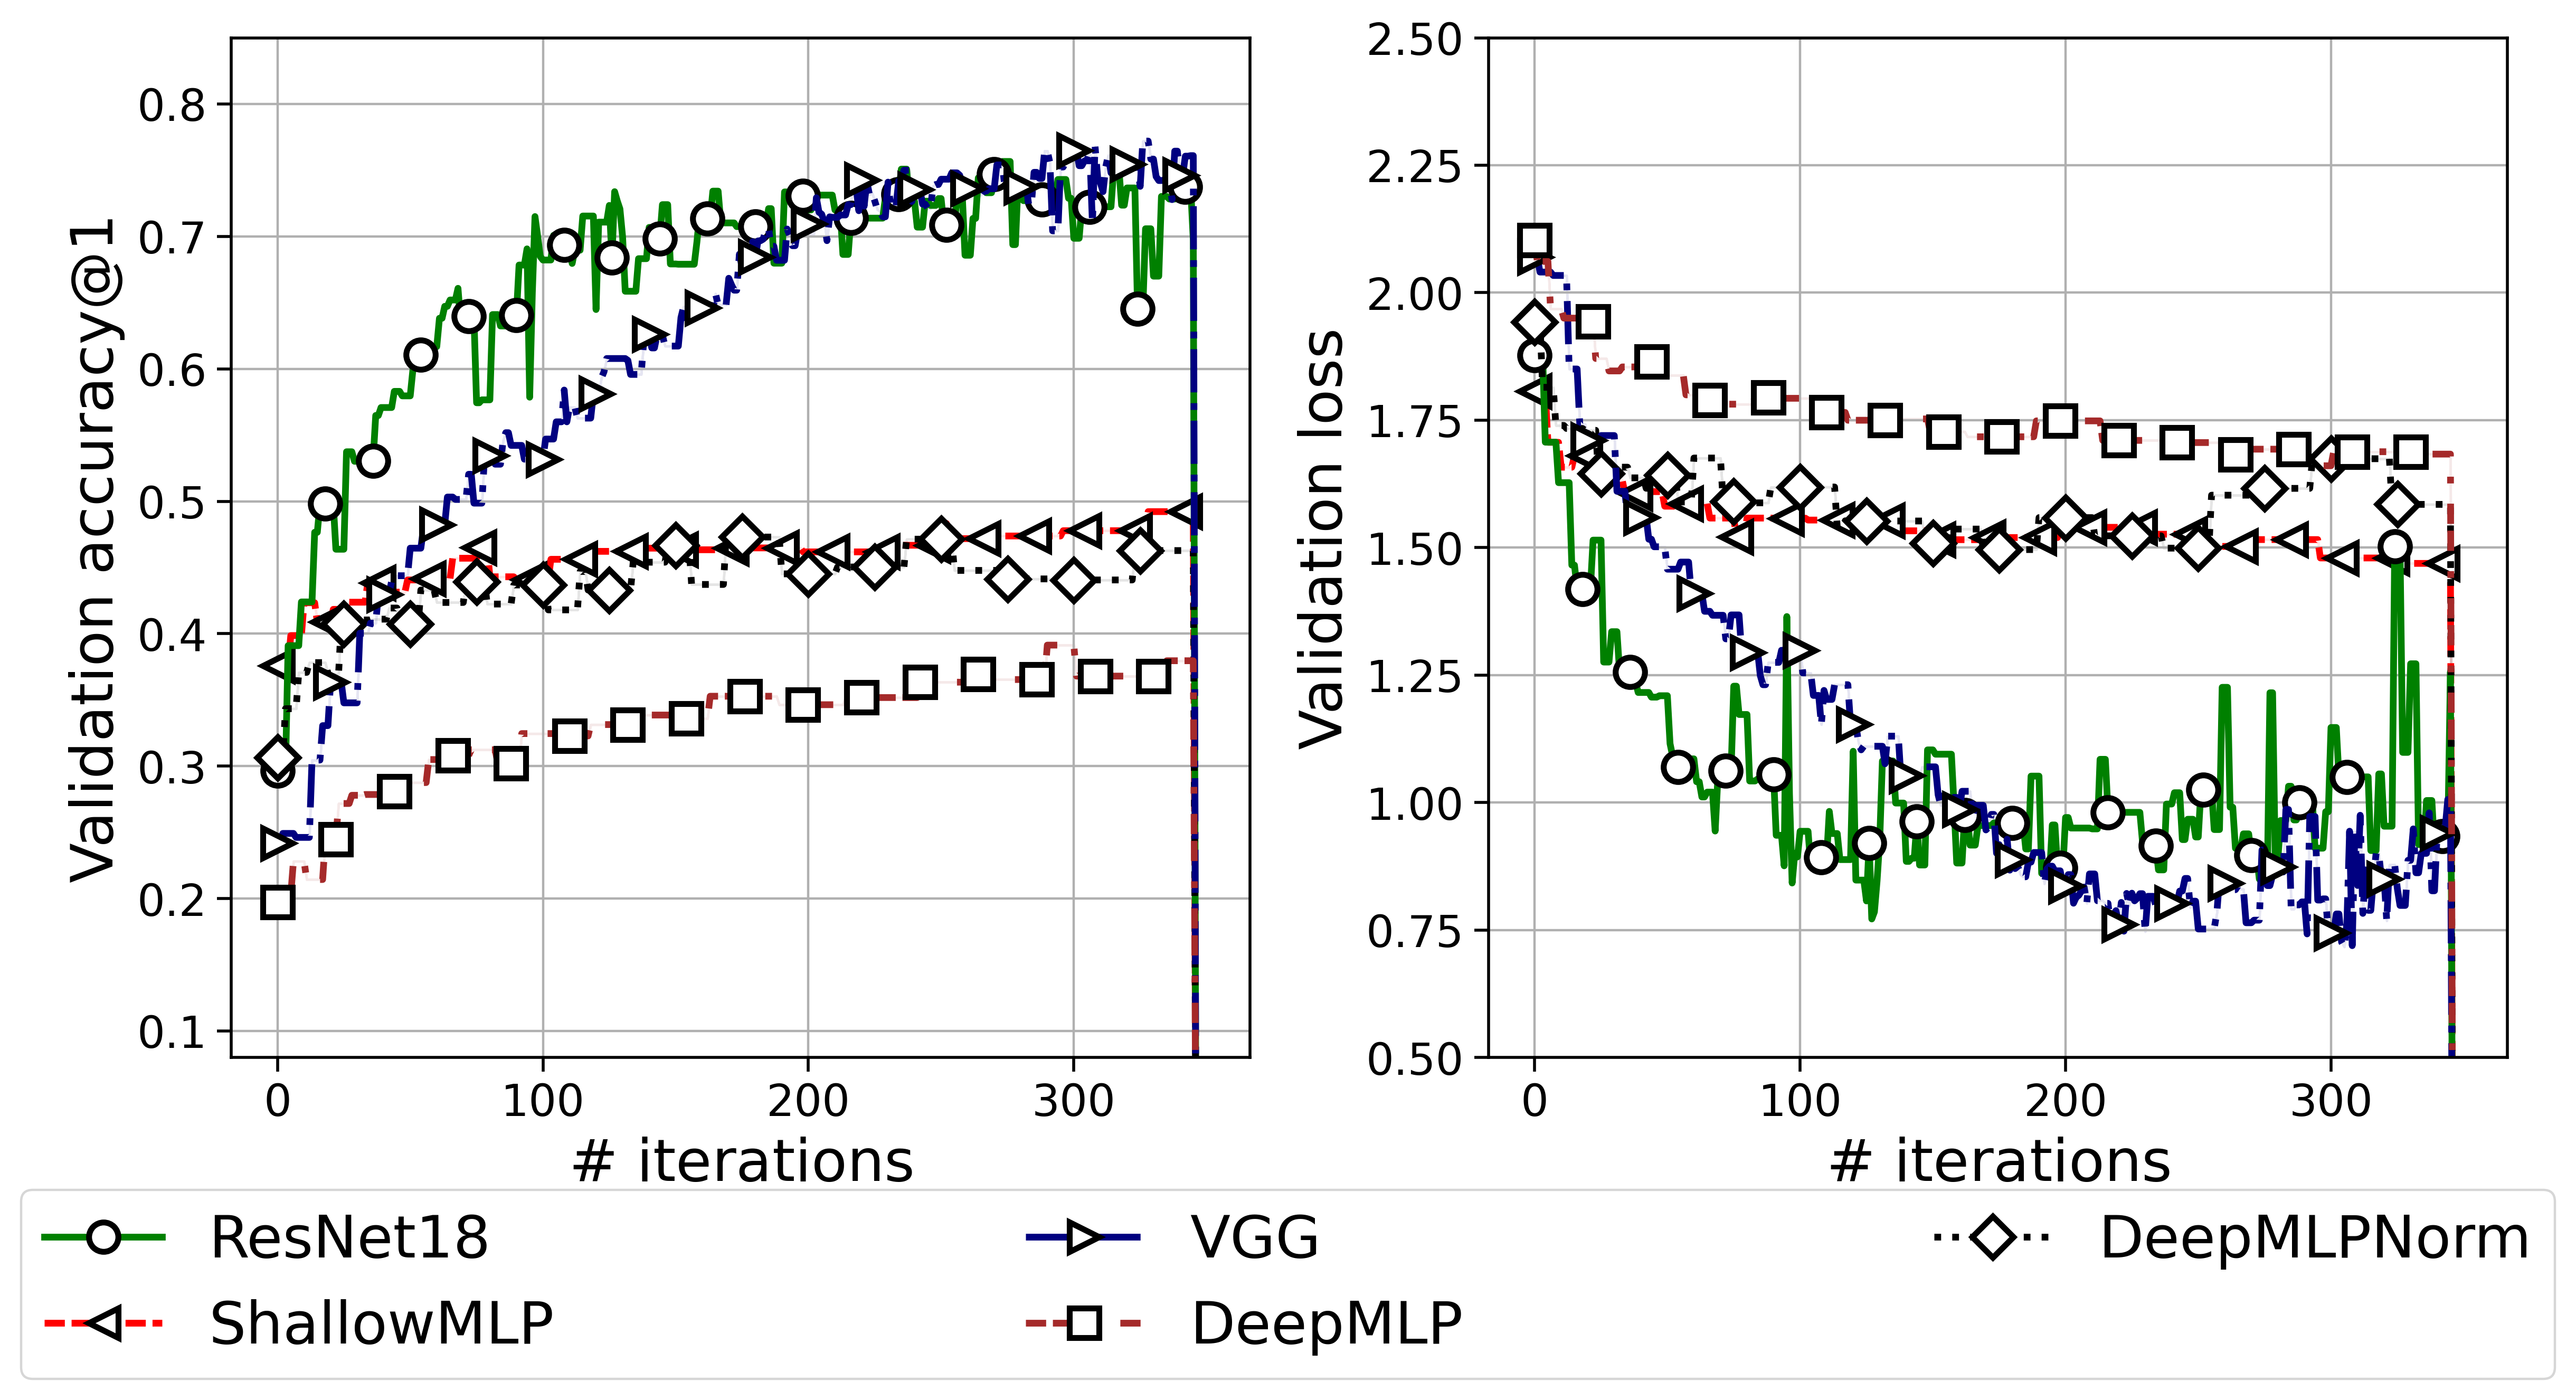

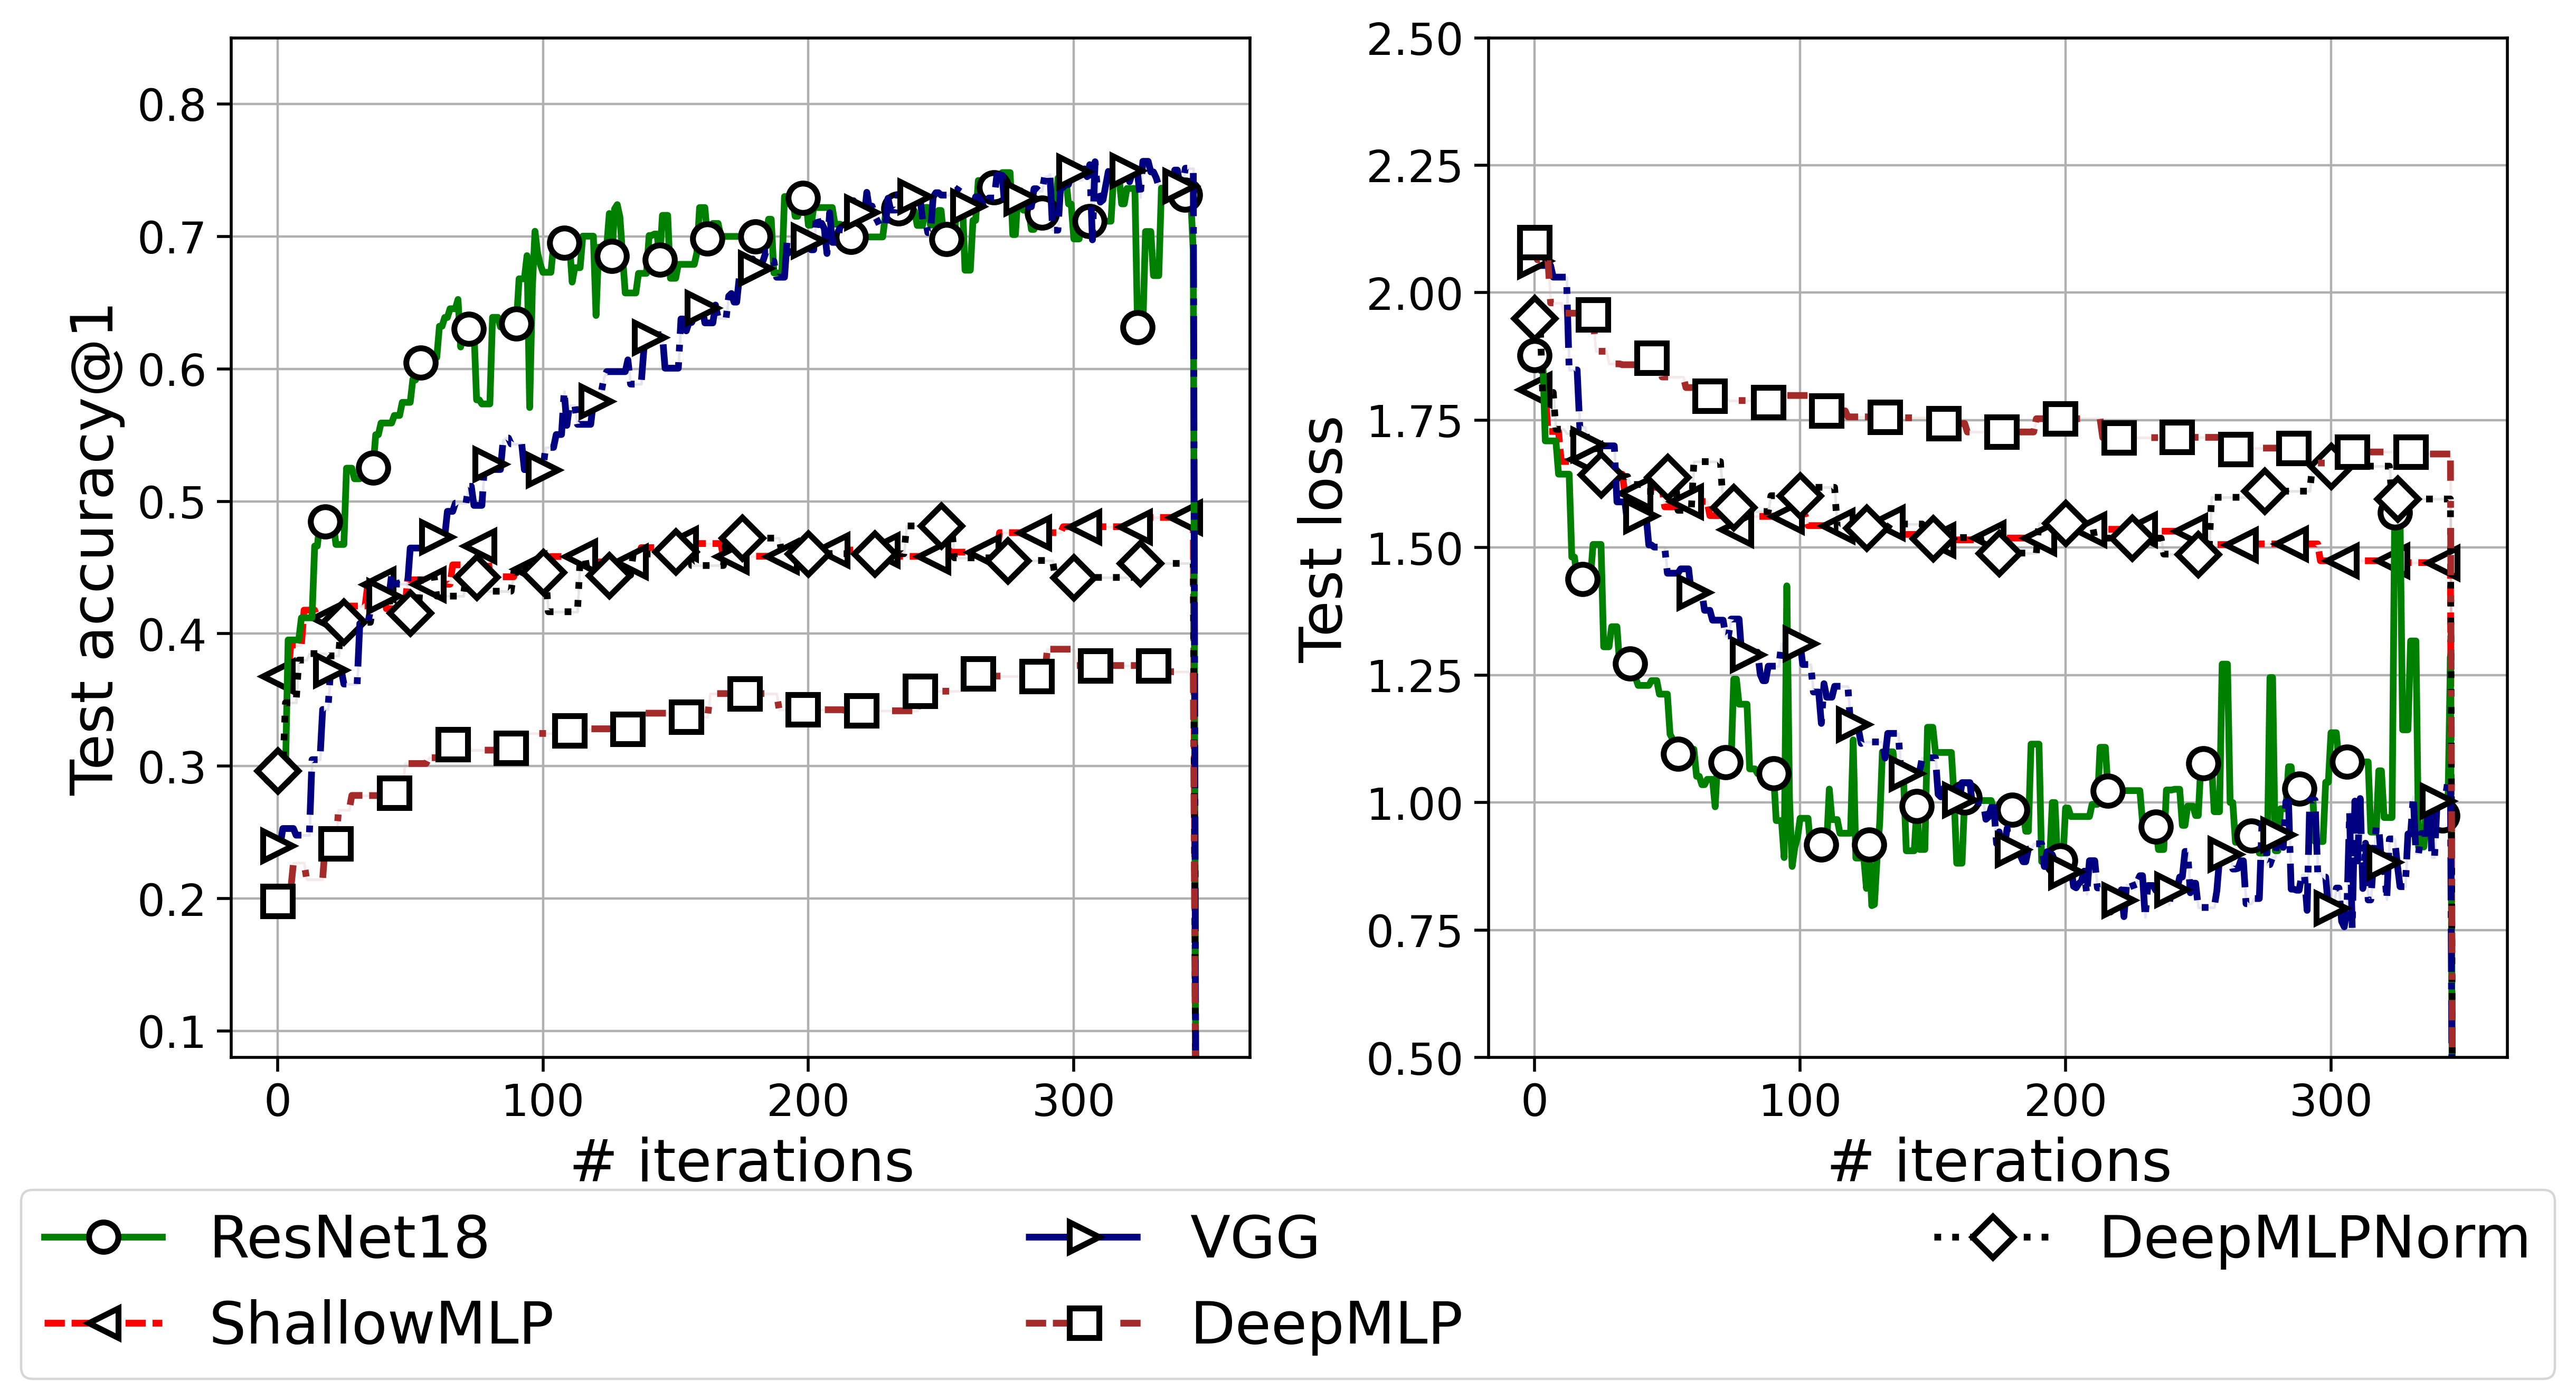

In [105]:

fig, ax, _ = get_fig_set_style(7, shape=(1,2), figsize=(12,6))
ax[1].grid()
plot_vals(ax[0], get_loss_hist("pull_rew.eval_rez.accuracy"), "Validation accuracy@1", (0.08, 0.85))
plot_vals(ax[1], get_loss_hist("pull_rew.eval_rez.loss"), " Validation loss", (0.5, 2.5))
h, legend_ = ax[0].get_legend_handles_labels()

pos = [1, 0, 3, 4, 2]
print(legend_)
legend_, h = [legend_[p] for p in pos], [h[p] for p in pos]
fig.legend(
    h,
    legend_,
    ncol=3,
    bbox_to_anchor=(0.0, -0.06, 1, 0.10),
    loc="outside upper left",
    mode="expand",
    borderaxespad=0,
)


fig.tight_layout()
# fig = fig.subplots_adjust(bottom=0.1)
figs = {"both": fig}

fig, ax, _ = get_fig_set_style(7, shape=(1,2), figsize=(12,6))
ax[1].grid()
plot_vals(ax[0], get_loss_hist('test_rew.accuracy',), "Test accuracy@1", (0.08, 0.85))
plot_vals(ax[1], get_loss_hist('test_rew.loss',), " Test loss", (0.5, 2.5))
h, legend_ = ax[0].get_legend_handles_labels()

pos = [1, 0, 3, 4, 2]
print(legend_)
legend_, h = [legend_[p] for p in pos], [h[p] for p in pos]
fig.legend(
    h,
    legend_,
    ncol=3,
    bbox_to_anchor=(0.0, -0.06, 1, 0.10),
    loc="outside upper left",
    mode="expand",
    borderaxespad=0,
)

fig.tight_layout()
# fig = fig.subplots_adjust(bottom=0.1)
figs = {"test_both": fig}
# ax.grid()


# figs = {}
# figs["acc"] = plot_vals(get_loss_hist("accuracy"), "Accuracy", (0.2, 1.))
# figs["loss"] = plot_vals(get_loss_hist("loss"), "Loss", (0.5, 2.1))